In [10]:
import ndlib
import networkx as nx
import ndlib.models.epidemics as ep
import json
import ndlib.models.ModelConfig as mc
import numpy as np
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline
import tkinter


from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

## Gillespie's direct algorithm ##
From the site of the book


In [2]:
####################################################################
###    This is the PYTHON version of program 6.4 from page 203 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR model (including births and deaths) with full    #
### (event-driven) demographic stochasticity.					   #
###																   #
### This is a more complex stochastic model as 6 events are		   #
### possible: infection, recovery, birth, death of susceptible,    #
### death of infected, death of recovered.					       #
### Note: by default we are using a very small population size 	   #
### to highlight the stochasticity.				   				   #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import numpy as np
import pylab as pl

beta=1.0
gamma=1/7.0
mu=1/70
N0=500
delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)
### You may want to try with popylation size of 50 (small) to see the events
### In this case uncomment the next line
#N0=50.0
ND=MaxTime=2*365.0
Y0=pl.ceil(mu*N0/gamma)
X0=pl.floor(gamma*N0/beta)
# Y0=5
# X0=8000
Z0=N0-X0-Y0

INPUT = np.array((X0,Y0,Z0))

timestep=0.0

def stoc_eqs(INP,ts): 
	V = INP
	Rate=np.zeros((7))
	Change=np.zeros((7,3))
	N=np.sum(V[range(3)])
	Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0]);
	Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1]);
	Rate[2] = mu*N;  Change[2,:]=([+1, 0, 0]);
	Rate[3] = mu*V[0];  Change[3,:]=([-1, 0, 0]);
	Rate[4] = mu*V[1];  Change[4,:]=([0, -1, 0]);
	Rate[5] = mu*V[2];  Change[5,:]=([0, 0, -1]);
	Rate[6] = delta;  Change[6,:]=([0, +1, 0]);
	R1=pl.rand();
	R2=pl.rand();
	ts = -np.log(R2)/(np.sum(Rate));
	list1 = np.cumsum(Rate)
	for i in range(len(list1)):
		if list1[i] >= R1*np.sum(Rate):
			V[range(3)] = V[range(3)]+Change[i,:]
			return [V,ts]


def Stoch_Iteration(INPUT):
    lop=0
    ts=0
    T=[0]
    S=[0]
    I=[0]
    R=[0]
    while T[lop] < ND:
        lop=lop+1
        T.append(T[lop-1]+ts)
        S.append(INPUT[0])
        I.append(INPUT[1])
        R.append(INPUT[2])
        [res,ts] = stoc_eqs(INPUT,ts)
#         lop=lop+1
#         T.append(T[lop-1])
#         S.append(INPUT[0])
#         I.append(INPUT[1])
#         R.append(INPUT[2])
    return [T,S,I,R]

In [3]:
## Variability ##

beta=1.0
gamma=1/7.0
mu=1/70
N0=500
delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)
ND=MaxTime=2*365.0
Y0=pl.ceil(mu*N0/gamma)
X0=pl.floor(gamma*N0/beta)
Z0=N0-X0-Y0

INPUT = np.array((X0,Y0,Z0))

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (10,5))
# fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
for i in range(4):
    [T,S,I,R]=Stoch_Iteration(INPUT)

    tT=np.array(T)[1:,]/365.
    tS=np.array(S)[1:,]
    tI=np.array(I)[1:,]
    tR=np.array(R)[1:,]

#     ax1.plot(tT, tS, alpha=0.5, label=('Iteration %s' %(i+1)))
#     ax1.set_ylabel("Susceptible", size = 15)
    ax2.plot(tT, tI, alpha=0.5, label=('Iteration %s' %(i+1)))
    ax2.set_ylabel("Infected", size = 15)
#     ax3.plot(tT, tR, alpha=0.5, label=('Iteration %s' %(i+1)))
#     ax3.set_ylabel("Recovered", size = 15)
    
plt.legend(loc = "upper left", fontsize = "x-large")
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# for tick in ax3.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)
fig.suptitle('The variability between \n different iterations ', size = 25, y = 1.06)
plt.xlabel ('Time (years)', size = 20)
plt.show()

<ipython-input-3-ec73ac89c4e4>:43: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [4]:
## Extinctions for different population size ##

beta=1
gamma=1/5.0
R0 = beta/gamma
print("R0 is: ", R0)
mu=1/(70*365)
# delta = 0.0005
Nlist = [50000, 500000, 5000000]

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (12, 6))
color = ['red', 'blue', 'green']

for Nvalue in range(3):
    N0 = Nlist[Nvalue]
    alfa = 0.9
    for iteration in range(3):
        Y0=pl.ceil(mu*N0/gamma)
        X0=pl.floor(gamma*N0/beta)
        Z0=N0-X0-Y0
        ND=MaxTime=365.0
        INPUT = np.array((X0,Y0,Z0))
        delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)

#         delta = 0.02
        print(delta)

        [T,S,I,R]=Stoch_Iteration(INPUT)


        tT=np.array(T)[1:,]/365.
        tS=np.array(S)[1:,]
        tI=np.array(I)[1:,]
        tR=np.array(R)[1:,]
        tN = tS + tI + tR

        if iteration == 1:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[Nvalue], label=('Population size of %s' %(N0)))
        else:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[Nvalue])
        ax2.set_ylabel("Infected", size = 20)
        alfa = alfa - 0.2
    
plt.legend(loc = "upper right", fontsize = "x-large", bbox_to_anchor = (1,1))
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
fig.suptitle('The frequency of extinctions \n for different population sizes ', size = 25, y = 1.06)
plt.xlabel ('Time (years)', size = 20)
plt.show()

R0 is:  5.0
0.002187933441780616
0.002187933441780616
0.002187933441780616
0.006918853044878156
0.006918853044878156
0.006918853044878156
0.02187933441780616
0.02187933441780616
0.02187933441780616


<ipython-input-4-40355bc377eb>:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [5]:
## Extinctions for different R0 ##

betalist = [0.25, 0.5, 1, 2, 4]
gammalist = [1/5, 1/5, 1/5, 1/5, 1/5]
# R0 = beta/gamma
# print("R0 is: ", R0)
mu=1/(70*365)
# delta = 0.0005
N0 = 500000

fig, (ax2) = plt.subplots(1, sharex=True)
color = ['red', 'blue', 'green', 'gray']

for R0value in range(3):
    beta = betalist[R0value]
    gamma = gammalist[R0value]
    alfa = 0.9
    for iteration in range(3):
        Y0=pl.ceil(mu*N0/gamma)
#         Y0 = 1
        X0=pl.floor(gamma*N0/beta)
        Z0=N0-X0-Y0
        ND=MaxTime=365.0
        INPUT = np.array((X0,Y0,Z0))
        delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)

#         delta = 0.0005
        print(beta/gamma)

        [T,S,I,R]=Stoch_Iteration(INPUT)


        tT=np.array(T)[1:,]/365.
        tS=np.array(S)[1:,]
        tI=np.array(I)[1:,]
        tR=np.array(R)[1:,]
        tN = tS + tI + tR

        if iteration == 1:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[R0value], label=('Iteration with R0: %s' %(beta/gamma)))
        else:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[R0value])
        ax2.set_ylabel("Infected", size = 20)
        alfa = alfa - 0.2
    
plt.legend(loc = "upper right", fontsize = "x-large", bbox_to_anchor = (1.8,1))
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
fig.suptitle('The frequency of extinctions \n for different R0 ', size = 25, y = 1.06)
plt.xlabel ('Time (years)', size = 20)
plt.show()

1.25
1.25
1.25
2.5
2.5
2.5
5.0
5.0
5.0


<ipython-input-5-167f2cba0959>:53: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## SIR Metapopulation model for humans
From the site of the book

In [6]:
#!/usr/bin/env python

####################################################################
###    This is the PYTHON version of program 7.2 from page 242 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR epidemic in a metapopulationFor simplicity births#
### and deaths have been ignored, and we work with numbers of      #
### individuals.                                                   #
### Y[i][j] refers to infected individual who are currently in i   #
### but live in j..                                                #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import scipy.integrate as spi
import numpy as np
import pylab as pl
from matplotlib.font_manager import FontProperties as fmp

n=5
beta=1*np.ones(n);
gamma=0.3*np.ones(n);
N0=np.zeros(n*n);
X0=np.zeros(n*n);
for i in np.arange(0,n*n,n+1):
	N0[i]=1000.0
	X0[i]=800.0

Y0=np.zeros(n*n); Y0[0]=1.0;
ND=MaxTime=60.
TS=1.0

l=np.zeros((n,n));r=np.zeros((n,n))
for i in range(n):
	for j in range(n):
		if abs(i-j)==1: 
			l[i][j]=0.1
r=2*np.ones((n,n)); r=r-np.diag(np.diag(r));
# print(r)

INPUT0=np.hstack((X0,Y0,N0))
INPUT = np.zeros((3*n*n))
for i in range(n*n):
	INPUT[3*i]=INPUT0[i]
	INPUT[1+3*i]=INPUT0[n*n+i]
	INPUT[2+3*i]=INPUT0[2*n*n+i]

# print(INPUT0)
# print(INPUT)

def diff_eqs(INP,t):  
	'''The main set of equations'''
	Y=np.zeros((3*n*n))
	V = INP   
	sumY=np.zeros(n)
	sumN=np.zeros(n)
	
	## Calculate number currently in Subpopulation i
	for i in range(n):
		sumY[i]=0.0;sumN[i]=0.0
		for j in range(n):
			k=3*(j+i*n);
			sumN[i]+=V[2+k];
			sumY[i]+=V[1+k];	
			
# 	print(sumY)

	## Set all rates to zeros
	for i in range(n):
		for j in range(n):
			k=3*(j+i*n);
			Y[k]=0; Y[1+k]=0; Y[2+k]=0

	for i in range(n):
		for j in range(n):		
			## Calculate the rates
			k = 3 * (j+i*n) 
			K = 3 * (i+j*n)
			h = 3 * (i+i*n)
			H = 3 * (j+j*n)
			
			Y[k] -= (beta[i]*V[k]*(sumY[i]/sumN[i]))
			Y[k+1] += (beta[i]*V[k]*(sumY[i]/sumN[i]))
			Y[k+1] -= (gamma[i]*V[k+1])
# 			print(Y)          
			
			## Movement
			Y[h] += r[j][i]*V[K]
			Y[h] -= l[j][i]*V[h]
			
			Y[h+1] += r[j][i]*V[K+1]
			Y[h+1] -= l[j][i]*V[h+1]
			
			Y[h+2] += r[j][i]*V[K+2]
			Y[h+2] -= l[j][i]*V[h+2]
			
			Y[k] += l[i][j]*V[H]
			Y[k] -= r[i][j]*V[k]
			
			Y[1+k] += l[i][j]*V[1+H]
			Y[1+k] -= r[i][j]*V[1+k]
			
			Y[2+k] += l[i][j]*V[2+H]
			Y[2+k] -= r[i][j]*V[2+k]
# 	print(Y)
	return Y   # For odeint

In [7]:
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
t_course = spi.odeint(diff_eqs,INPUT,t_range)
# print(t_course[1])
tc = t_course

### Plotting
totalS=np.zeros((len(tc),n))
totalI=np.zeros((len(tc),n))

for i in range(n):
	for j in range(n):
		k=3*(j+i*n);
		totalS[:,i]+=tc[:,k]
		totalI[:,i]+=tc[:,k+1]


#print len(totalS)
plt.subplot(211)
for i in range(n):
	plt.plot(t_range,totalS[:,i], label=('Subpopulation %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Susceptibles')
plt.legend(loc = "upper right", fontsize = 8)
plt.subplot(212)
for i in range(n):
	plt.plot(t_range,totalI[:,i], label=('Subpopulation %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Infectious')
plt.legend(loc = "upper right", fontsize = 8)

plt.show()

<ipython-input-7-c776d16895cc>:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Metapopulation with stochasticity 

In [13]:
def stoc_eqs(INP,ts): 
    for sub in range(nsub): 
        V = INP
        Rate=np.zeros((6))
        Change=np.zeros((6,3))
        N=np.sum(V[sub])
        sumlambda = 0
        for subs in range(nsub):          ## sum for lambda i
            if N == 0:
                sumlambda = 0 
#             if sub == subs:
#                 sumlambda = V[sub][1]/N
#             else:
            sumlambda += rho[sub][subs]*V[subs][1]/N
#             print(sub)
#             print(subs)
#             print(rho[sub][subs])
#             print(sumlambda)
            
        Rate[0] = beta*sumlambda*V[sub][0]; Change[0,:]=([-1, +1, 0]);
        Rate[1] = gamma*V[sub][1];  Change[1,:]=([0, -1, +1]);
        Rate[2] = mu*N;  Change[2,:]=([+1, 0, 0]);
        Rate[3] = mu*V[sub][0];  Change[3,:]=([-1, 0, 0]);
        Rate[4] = mu*V[sub][1];  Change[4,:]=([0, -1, 0]);
        Rate[5] = mu*V[sub][2];  Change[5,:]=([0, 0, -1]);
        R1=pl.rand();
        list1 = np.cumsum(Rate)
#         print(list1)
#         print(np.sum(Rate))
        for i in range(len(list1)):
            if list1[i] >= R1*np.sum(Rate):
                for compartment in range(3):
                    V[sub][compartment] = V[sub][compartment]+Change[i][compartment]
                break
    R2=pl.rand();
    ts = -np.log(R2)/(np.sum(Rate));
    return [V,ts]


def Stoch_Iteration(INPUT):
    lop=0
    ts=0
    T=[0]
    S=[[0] for x in range(nsub)]
    I=[[0] for x in range(nsub)]
    R=[[0] for x in range(nsub)]
    while T[lop] < ND:
        lop=lop+1
        T.append(T[lop-1]+ts)
        for sub in range(nsub):
#             print(INPUT[sub][0])
            S[sub].append(INPUT[sub][0])
            I[sub].append(INPUT[sub][1])
#             print(sub)
#             print(INPUT)
            R[sub].append(INPUT[sub][2])
        [INPUT,ts] = stoc_eqs(INPUT,ts)
#         lop=lop+1
#         T.append(T[lop-1])
#         print(T[lop-1])
    return [T,S,I,R]

[[1.e+00 0.e+00 0.e+00]
 [1.e-05 1.e+00 0.e+00]
 [0.e+00 1.e-05 1.e+00]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]
[[0], [0], [0]]


IndexError: index 6 is out of bounds for axis 0 with size 6

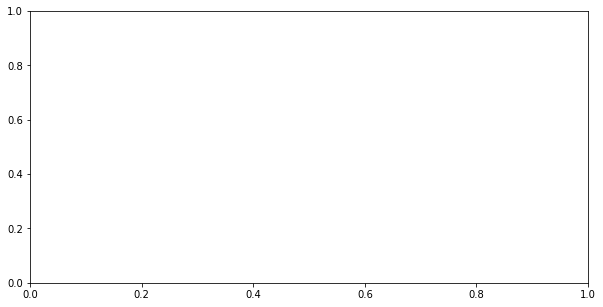

In [134]:
beta=1
gamma=1/7.0
mu=0.0001
N0=500
rhoij = 0.00001
rhoji = 0.001
rho = [[1,rhoij],[rhoji,1]]
nsub = 3
rho = np.zeros((nsub,nsub))
for pop in range(nsub):
    for sub in range(nsub):
        if pop == sub:
            rho[pop][sub] = 1
            if pop < nsub-1:
                if sub < nsub-1:
#                     rho[pop][sub+1] = rhoij
                    rho[pop+1][sub] = rhoij
#         if pop == sub+1:
#             rho[pop][sub+1] = rhoij
#             print(pop)
#             print(sub+1)
#             print(rho[pop][sub+1])
#         print(rho)
#         if pop+1 == sub:
#             rho[pop+1][sub] = rhoij
            
            
print(rho)
ND=MaxTime=365.0*100
Y01=100
X01=N0-Y01
# Y01=pl.ceil(mu*N0/gamma)
# X01=pl.floor(gamma*N0/beta)
Z01=N0-X01-Y01

Y02=0
X02=N0-Y02
# Y02=0
# X02=pl.floor(gamma*N0/beta)
Z02=N0-X02-Y02

INPUT01 = [[X01,Y01,Z01]]
INPUT = INPUT01 + [[X02,Y02,Z02] for x in range(nsub-1)]


timestep=0.0

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (10,5))

for i in range(1):
    INPUT = INPUT01 + [[X02,Y02,Z02] for x in range(nsub-1)]
    [T,S,I,R]=Stoch_Iteration(INPUT)
    
    tT=T
    tS=S
    tI=I
    tR=R

    alfa = 1
    for sub in range(nsub):
        ax2.plot(tT[1:], tI[sub][1:], alpha=0.5, label=('Iteration {} for population {}'.format(i+1, sub+1)))
ax2.set_ylabel("Infected", size = 15)
# ax2.set_xlim(0,250)

    
plt.legend(loc = "upper right", fontsize = "x-large")
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# for tick in ax3.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)
fig.suptitle('The variability between \n different iterations ', size = 25, y = 1.06)
plt.xlabel ('Time (days)', size = 20)
plt.show()

In [137]:
def stoc_eqs(INP,ts): 
    V = INP
    Change=np.zeros((6,3))
    sumlambda = [[0] for x in range(nsub)]
    print(sumlambda)
    Rate=np.zeros((nsub,6))
    for sub in range(nsub): 
        N=np.sum(V[sub])
        if N == 0:
            sumlambda[sub] = 0 
        sumlambda[sub] += rho[sub][sub]*V[sub][1]/N
        print(sumlambda)
        Rate[sub][0] = beta*sumlambda[sub]*V[sub][0]; Change[0,:]=([-1, +1, 0]);
        Rate[sub][1] = gamma*V[sub][1];  Change[1,:]=([0, -1, +1]);
        Rate[sub][2] = mu*N;  Change[2,:]=([+1, 0, 0]);
        Rate[sub][3] = mu*V[sub][0];  Change[3,:]=([-1, 0, 0]);
        Rate[sub][4] = mu*V[sub][1];  Change[4,:]=([0, -1, 0]);
        Rate[sub][5] = mu*V[sub][2];  Change[5,:]=([0, 0, -1]);
        R1=pl.rand();
        list1 = np.cumsum(Rate)
        for i in range(len(list1)):
            if list1[i] >= R1*np.sum(Rate):
                for compartment in range(3):
                    V[sub][compartment] = V[sub][compartment]+Change[i][compartment]
                break
    R2=pl.rand();
    ts = -np.log(R2)/(np.sum(Rate));
    return [V,ts]


def Stoch_Iteration(INPUT):
    lop=0
    ts=0
    T=[0]
    S=[[0] for x in range(nsub)]
    I=[[0] for x in range(nsub)]
    R=[[0] for x in range(nsub)]
    while T[lop] < ND:
        lop=lop+1
        T.append(T[lop-1]+ts)
        for sub in range(nsub):
#             print(INPUT[sub][0])
            S[sub].append(INPUT[sub][0])
            I[sub].append(INPUT[sub][1])
#             print(sub)
#             print(INPUT)
            R[sub].append(INPUT[sub][2])
        [INPUT,ts] = stoc_eqs(INPUT,ts)
#         lop=lop+1
#         T.append(T[lop-1])
#         print(T[lop-1])
    return [T,S,I,R]

Stoch_Iteration(INPUT)

[[0], [0], [0]]
[array([0.244]), [0], [0]]
[array([0.244]), array([0.028]), [0]]
[array([0.244]), array([0.028]), array([0.022])]


IndexError: index 12 is out of bounds for axis 0 with size 6